## SHAPのサンプルコード

In [1]:
%load_ext lab_black

In [2]:
# ライブラリの読み込み
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

# SHAP(SHapley Additive exPlanations)
import shap

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# dataの用意
X, y = shap.datasets.boston()  # ボストンの住宅価格データ
X.shape
# (506, 13)

X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### モデル作成(XGBoost)

In [5]:
params = {
    "n_estimators": 100,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "ls",
}

xgb = XGBRegressor(**params)

params_search = {"n_estimators": [10, 100, 1000]}
grid = GridSearchCV(xgb, params_search, cv=10, n_jobs=-1, verbose=True)
grid.fit(X_train, y_train)

print("Grid best parameter: ", grid.best_params_)

params = {
    "n_estimators": grid.best_params_["n_estimators"],
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "ls",
}

xgb = XGBRegressor(**params)
xgb.fit(X_train, y_train)

# 一応確認
print(mean_absolute_error(y_train, xgb.predict(X_train)))
print(mean_absolute_error(y_test, xgb.predict(X_test)))

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[13:24:22] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Grid best parameter:  {'n_estimators': 1000}
[13:24:23] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { loss, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.34361783097692805
2.526548535572855


### 予測結果の確認


In [6]:
# 予測結果
y_pred = xgb.predict(X_train)

# 最初の5レコード分の予測値
print(y_pred[0:5].round(1))

# 予測値の平均
y_pred.mean()

# 訓練データの特徴量
X_train.head()

[14.3 24.3 17.8 22.9 20.4]


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
141,1.62864,0.0,21.89,0.0,0.624,5.019,100.0,1.4394,4.0,437.0,21.2,396.90,34.41
272,0.11460,20.0,6.96,0.0,0.464,6.538,58.7,3.9175,3.0,223.0,18.6,394.96,7.73
135,0.55778,0.0,21.89,0.0,0.624,6.335,98.2,2.1107,4.0,437.0,21.2,394.67,16.96
298,0.06466,70.0,2.24,0.0,0.400,6.345,20.1,7.8278,5.0,358.0,14.8,368.24,4.97
122,0.09299,0.0,25.65,0.0,0.581,5.961,92.9,2.0869,2.0,188.0,19.1,378.09,17.93


### SHAP値の計算

In [7]:
explainer = shap.TreeExplainer(xgb)

# SHAP値は「shap._explanation.Explanation」で持つか、array型で持つかで出し方が少し変わる
shap_values = explainer(X_train)  # shap._explanation.Explanation型の場合
shap_values_ar = explainer.shap_values(X_train)  # numpy.ndarray型の場合
print("shap_values: ", type(shap_values))
print("shap_values_ar: ", type(shap_values_ar))

shap_values:  <class 'shap._explanation.Explanation'>
shap_values_ar:  <class 'numpy.ndarray'>


### waterfall

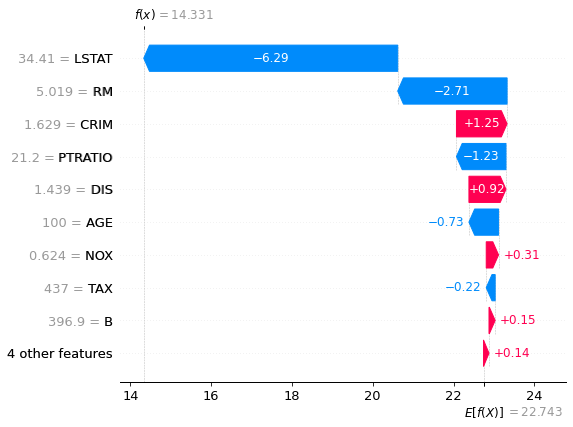

In [8]:
# 訓練データの1レコード目の各特徴量のSHAP値を滝グラフで可視化
shap.plots.waterfall(shap_values[0])

### decision_plot

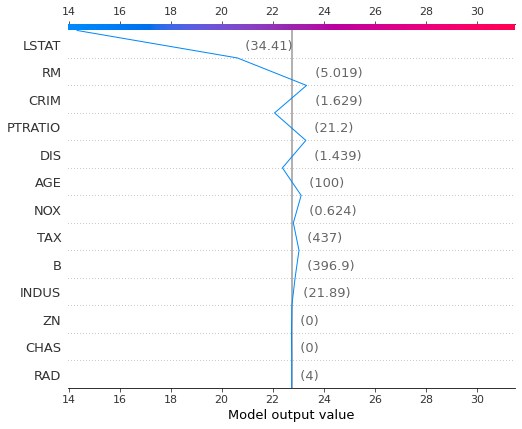

In [9]:
# 訓練データの1レコード目の各特徴量が予測結果に与える影響を可視化
# モデルのbase valueはグラフ中央付近のグレーの線で、グラフ上部の目盛りと折れ線の接点が最終的な予測値になっている
# 各特徴量がbase valueにどの程度作用して最終的な予測値になっているかがわかるようになっている
shap.decision_plot(explainer.expected_value, shap_values_ar[0], X_train.iloc[[0], :])

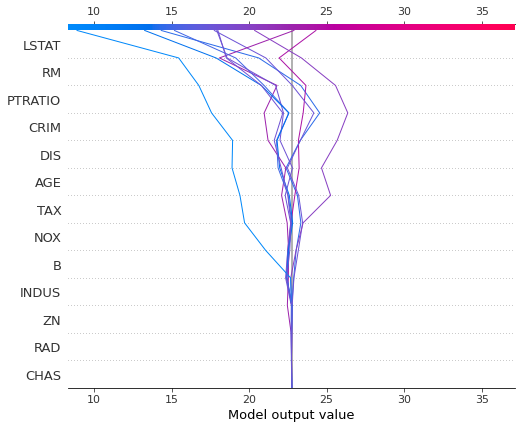

In [10]:
# 訓練データの10レコード分をdesicion_plotで可視化した場合
shap.decision_plot(
    explainer.expected_value, shap_values_ar[0:10], X_train.iloc[0:10, :]
)

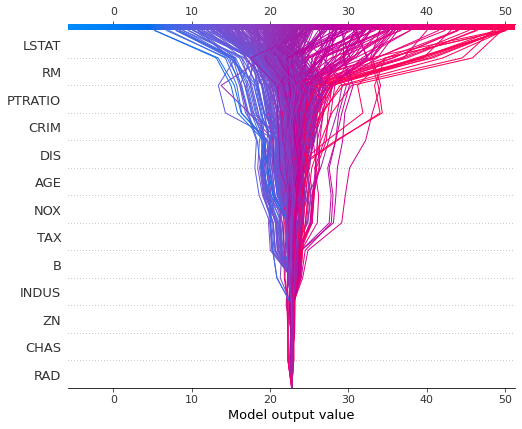

In [11]:
# 訓練データの全てをdesicion_plotで可視化した場合
shap.decision_plot(explainer.expected_value, shap_values_ar, X_train)

### force_plot

In [12]:
# 訓練データの1レコード目の各特徴量のSHAP値を数直線上で可視化
shap.initjs()
shap.plots.force(shap_values[0])

In [13]:
# 訓練データの初めの3レコードについてSHAP値を可視化
shap.initjs()
num = 3
shap.force_plot(explainer.expected_value, shap_values_ar[0:num], X_train.iloc[0:num, :])

In [14]:
# 訓練データの全レコードについてSHAP値を可視化
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_ar, X_train)

### summary_plot

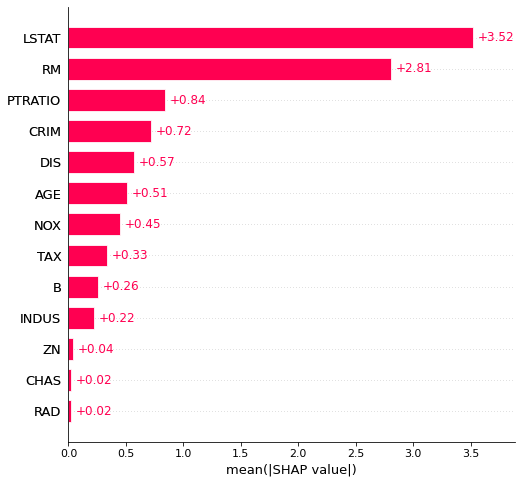

In [15]:
# 各特徴量のSHAP値の絶対値の平均(つまり、各特徴量の予測に対する寄与度)を棒グラフで表示
# 予測に対する寄与度が大きい順にソートされて表示される
shap.plots.bar(shap_values, max_display=20)  # max_displayで表示する変数の最大数を指定

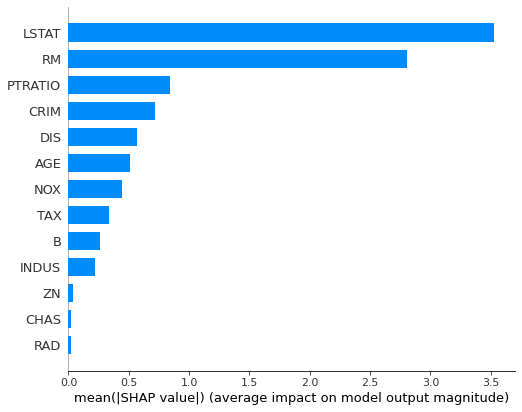

In [16]:
# 少し見た目が異なるが、以下でも同じグラフが作れる
shap.summary_plot(
    shap_values_ar, X_train, show=True, plot_type="bar", max_display=20
)  # max_displayで表示する変数の最大数を指定

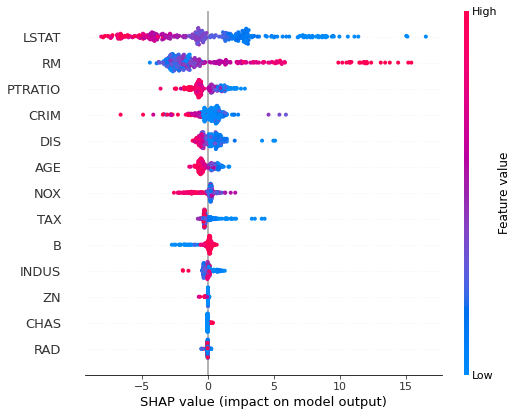

In [17]:
# 全サンプルについて、各特徴量のSHAP値の分布を可視化したもの
# 上記の棒グラフ同様、予測に対する寄与度が大きい順にソートされて表示される
# 色は特徴量の値の大小を表している(赤が大きくて青が小さい)
# LSTATの値が小さいほど予測値(住宅価格)は大きくなることがわかる
shap.plots.beeswarm(shap_values, max_display=20)  # max_displayで表示する変数の最大数を指定

# 以下でも同じ結果が得られる
# shap.summary_plot(shap_values_ar, X_train, show=True)

### dependence_plot

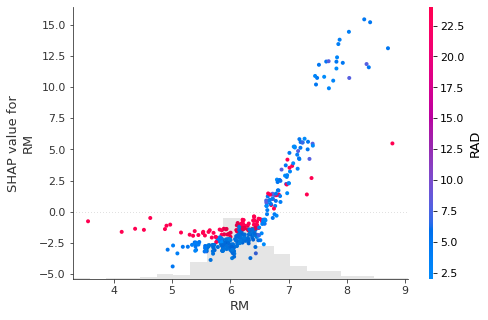

In [18]:
# ある1つの特徴量(今回はRM)について、訓練データ全体でのその特徴量(RM)の値と、対応するSHAP値の散布図を作成
# 横軸が特徴量の値、縦軸が対応するSHAP値
# SHAP値は予測値に対する特徴量の寄与を示すので、この図から、RMが変化したら予測値がどう変化するか読み取れる
# RMが大きいほどSHAP値は大きい、つまり、home priceが大きくなることを示している

# また、このグラフでは選択した特徴量(RM)と他の特徴量との相互作用も確認できるようになっていて
# color引数にshap値の変数を指定すると、自動的に適した変数が選択される
# 今回はRADが選ばれていて、RADの大小によって、同じRMでもSHAP値が異なることが確認できる
shap.plots.scatter(shap_values[:, "RM"], color=shap_values)

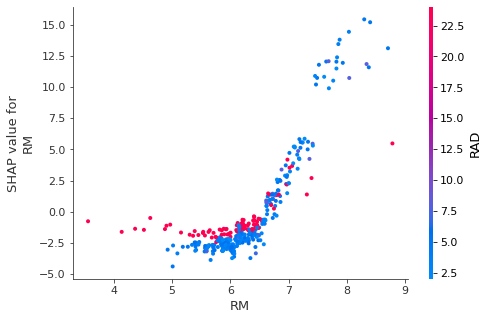

In [19]:
# 以下でも似たグラフが描画できる。ヒストグラムは付いてこない
shap.dependence_plot("RM", shap_values_ar, X_train, show=True)